In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import torch
# from torch import nn
# from torch.utils.data import DataLoader, Dataset
import itertools

data = pd.read_csv("x_train_id.csv")
data_y = pd.read_csv("y_train_id.csv")
data_test = pd.read_csv("x_test_id.csv")


# Assignment 2
**By Team 23, consisting of:**

*Michaèl Kersten, 1653652*

*Rohan Shetty, 1829114*

*Joshua Schweikart Dumoulin, 1718088*

# Problem Analasys

Given about the problem is that a set of fence lengths is given. The most optimal way to connect these fences, maximizing the area of the enclosed space, is by putting their corners on a circle. A single piece of line on the unit circle would look like this: 

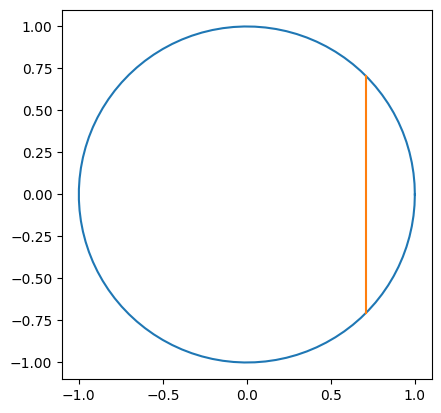

In [16]:

# Plot a circle
theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
plot = plt.plot(x, y)

# Plot a line on the circle
theta_start = (7*2*np.pi)/8
theta_end = (2*np.pi)/8
line = plt.plot([np.cos(theta_start), np.cos(theta_end)], [np.sin(theta_start), np.sin(theta_end)])

plt.gca().set_aspect('equal', adjustable='box')


A line piece could be placed somewhere on the circle, and the circumference of the circle between the ends of the line is always the same regardless of the location of the line. This area can be calculated by obtaining the angle between the two points intercepting the circle and the center of the circle, as per the following formula:

$$\theta =  2\arcsin(\frac{l}{2r}),$$
with l the length of the line and d the diameter of the circle. 

The length of the circle enclosed by this angle can be calculated by the following formula:
$$C_l = r\theta,$$

The area which is enclosed by a piece of a line is thus entirely independent of the location on the circle of the line. Thus, the 7 pieces of wall can be put into any arbitrary order on the circle, while the area enclosed by the circle will always be the same. However, this does not prove that the area enclosed by the pieces would also be unrelated to the order in which the pieces are placed.

The difference in the enclosed caused by the difference in order of the pieces is however presumed to be minimal. To prove this hypothesis, a function to calculate the area enclosed by a set of lines is defined as following: 


In [23]:
def get_radius(lines):
    circle_radius = max(lines) # Start with a circle that is big enough to fit any line
    error = 1
    error_threshold = 0.0001
    while abs(error) > error_threshold:
        circle_radius -= error * 0.1
        theta_sum = 0
        theta_list = []
        for line in lines:
            theta_sum += 2*np.arcsin(line/(2*circle_radius))
            theta_list.append(2*np.arcsin(line/(2*circle_radius)))
        error = abs(2*np.pi - theta_sum)
        # print(str(circle_radius) + " " + str(error) + " " + str(theta_sum))
        
    return circle_radius, theta_list

# Print an example output
print(get_radius([1, 1, 3, 3, 2, 2, 1]))
    

(2.1941862253411646, [0.4597892356460431, 0.4597892356460431, 1.5054353846402342, 1.5054353846402342, 0.9464288730529818, 0.9464288730529818, 0.4597892356460431])


This function calculates the radius and a list of theta values for each line.

Next up the coordinates of the points on the circle are calculated:

[2.1941862253411646, 1.9663113101560339, 1.3300179864926525, -1.6545419506003711, -1.546148864125762, 0.3592944425175496, 1.9662245612843123, 2.1941862253411646] [0.0, 0.9736904143665838, 1.7451376298398185, 1.441160686800895, -1.5568804968396013, -2.1645694017639885, -0.973865579060694, 0.0]


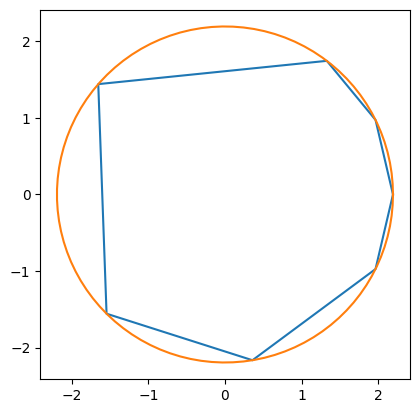

In [31]:
def get_coordinates(radius, theta_list):
    x = []
    y = []
    for i in range(len(theta_list)):
        x.append(radius*np.cos(sum(theta_list[:i])))
        y.append(radius*np.sin(sum(theta_list[:i])))
    x.append(x[0]) # Close the shape
    y.append(y[0])
    return x, y

example_radius, example_theta_list = get_radius([1, 1, 3, 3, 2, 2, 1])
x_ample, y_xample = get_coordinates(example_radius, example_theta_list)

print(x_ample, y_xample)
plt.plot(x_ample, y_xample)
# Plot a circle with the same radius:
theta = np.linspace(0, 2*np.pi, 100)
x = example_radius*np.cos(theta)
y = example_radius*np.sin(theta)
plot = plt.plot(x, y)
plt.gca().set_aspect('equal', adjustable='box')

This example graph shows that the code generating the coordinates of the points on the circle works as intended. Next, the area enclosed by the lines is calculated:

In [32]:
# The Shoelace formula is used to calculate the area of the enclosed space. This function is taken from https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

PolyArea(x_ample, y_xample)

11.915177399454102

Now that this is done, the effect of the of the order of the lines on the area enclosed can be tested. For this, the top 100 values from x_train are taken, and all permutations of these values are calculated. The differences in the area enclosed by the circle are calculated and stored for each permutation.

In [84]:

data_picked = data.iloc[:100, 1:].values
data_picked

array([[1.45770884e+00, 4.58178788e-01, 9.76732314e-01, 6.35680616e-01,
        8.22482765e-01, 6.38265833e-02, 1.44083166e+00],
       [3.48145127e-01, 4.81556684e-01, 4.55865651e-01, 1.25235051e-01,
        1.82391071e+00, 4.66657281e-01, 1.73217738e+00],
       [3.08692038e-01, 1.63639629e+00, 4.76993948e-01, 1.80839586e+00,
        2.62033731e-01, 8.99723530e-01, 1.20000087e-01],
       [1.37495172e+00, 1.36424556e-01, 1.43820500e+00, 1.25760019e-01,
        8.01193893e-01, 3.05272818e-01, 1.54717720e+00],
       [1.22627579e-01, 8.87379870e-02, 5.03917672e-02, 1.42760980e+00,
        1.01864111e+00, 5.89683473e-01, 1.96448314e+00],
       [6.03973866e-01, 1.66134071e+00, 6.30608439e-01, 6.09175503e-01,
        4.10866916e-01, 2.82278448e-01, 1.53598964e+00],
       [2.00970247e-01, 1.24097180e+00, 5.51373661e-01, 4.17838961e-01,
        1.65081632e+00, 2.08671559e-02, 1.56720424e+00],
       [4.27633047e-01, 3.08260292e-01, 6.44263923e-01, 6.68307304e-01,
        9.97379959e-01, 4

In [85]:

def get_permutation_differences(lines):
    # print(lines)
    permutation_list = itertools.permutations(lines)
    # print(permutation_list)
    permutation_lengths = []
    for permutation in permutation_list:
        radius, theta_list = get_radius(permutation)
        x, y = get_coordinates(radius, theta_list)
        permutation_lengths.append(PolyArea(x, y))
        
    permutation_differences = permutation_lengths - np.mean(permutation_lengths)
    return permutation_differences

permavgs = []
for lines in data_picked:
    
    permavgs.append(get_permutation_differences(lines))

sane_permavgs = np.array(permavgs)
sane_permavgs_filter = np.isnan(sane_permavgs).any(axis=1)
sane_permavgs = sane_permavgs[~sane_permavgs_filter]
# Get the average of every row
sane_permavgs_mean = np.mean(sane_permavgs, axis=1)
sane_permavgs_mean_mean = np.mean(sane_permavgs_mean)
print(sane_permavgs_mean_mean)

C:\Users\20212024\AppData\Local\Temp\ipykernel_17168\1028327055.py:10: RuntimeWarning: invalid value encountered in arcsin
  theta_sum += 2*np.arcsin(line/(2*circle_radius))
C:\Users\20212024\AppData\Local\Temp\ipykernel_17168\1028327055.py:11: RuntimeWarning: invalid value encountered in arcsin
  theta_list.append(2*np.arcsin(line/(2*circle_radius)))


-4.3778574579083546e-18


The average difference in the area enclosed by the circle is calculated to be very close to 0. This error is so close to 0 that the discrepancy might be caused by the uncertainty in the calculation of the area of the circle. This is a strong indication that the order of the lines only very minimally to not at all effects the area enclosed by the circle.

As the fence parts are in metres and the enclosed area is in metres squared, this can be considered to be an indication that if a function of weights would be implemented, it would need to have a square relation:

$$\text{Area} = (\sum_{i=1}^{n} w_i \cdot l_i)^2$$

This would mean that when the line segments are scaled, the area enclosed would be scaled by the square of that scaling factor.

Graphing the relation between these values (while using a constant weight of 1, as all pieces of the lines of the circle had been shown  to be nearly equal) yields the following graph: 

In [92]:
data_y_noID = data_y.iloc[:, 1:].values
data_y_noID

array([[2.35593987],
       [1.72354054],
       [1.8322686 ],
       ...,
       [1.8721087 ],
       [1.46688712],
       [2.50957131]])

In [91]:
data_noID = data.iloc[:, 1:].values
data_noID

array([[1.45770884, 0.45817879, 0.97673231, ..., 0.82248276, 0.06382658,
        1.44083166],
       [0.34814513, 0.48155668, 0.45586565, ..., 1.82391071, 0.46665728,
        1.73217738],
       [0.30869204, 1.63639629, 0.47699395, ..., 0.26203373, 0.89972353,
        0.12000009],
       ...,
       [0.34589365, 0.61857355, 1.8588562 , ..., 0.69796461, 0.41694984,
        1.50953996],
       [0.97773927, 0.15417026, 0.18600157, ..., 0.68824011, 0.14025059,
        1.99765134],
       [0.17478812, 1.1796242 , 0.8482675 , ..., 1.27098775, 0.53555107,
        0.69757539]])

In [93]:
sum_vals = np.sum(data_noID, axis=1)
sum_vals_squared = np.square(sum_vals)
sum_vals_squared

array([34.2861959 , 29.52344261, 30.38474004, ..., 30.52661195,
       26.33806346, 35.37376717])

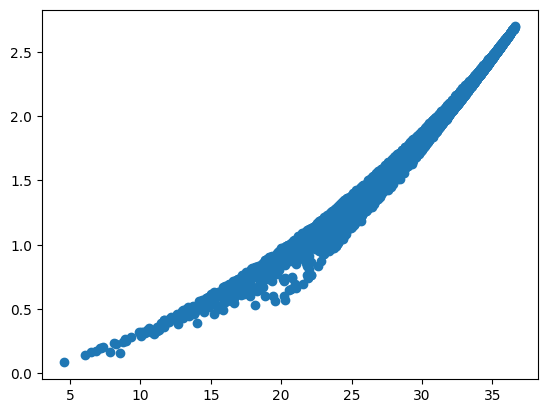

In [94]:

plt.scatter(sum_vals_squared, data_y_noID)

As is shown in this graph, this is almost the right relation, but a slight curve can still be seen. This is highly likely due to the effect of the sin-term in the formula used to calculate the area of the circle. 